# Setup

## Import packages

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from scipy.stats import zscore
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def sns_joint_equal_axes(g):
    
    g.ax_joint.set_aspect('equal')
    
    # Get the position of the joint plot and marginal plots
    joint_position = g.ax_joint.get_position()
    xmarg_position = g.ax_marg_x.get_position()
    ymarg_position = g.ax_marg_y.get_position()

    # Set the position and size of the x-axis marginal plot
    g.ax_marg_x.set_position([xmarg_position.x0, joint_position.y1 + 0.02, joint_position.width, xmarg_position.height])

    # Set the position and size of the y-axis marginal plot
    g.ax_marg_y.set_position([ymarg_position.x0, joint_position.y0, ymarg_position.width, joint_position.height])
    
    return g


def pairwise_distances(df, target_ids, dimensions = ['soma_x', 'soma_y_adj', 'soma_z'], source_ids = None, source_coords = None):
    # Extract source coordinates
    if source_ids is not None:
        # source_ids is a tuple of ('column_name',[column_values])
        source_coords = df[df[source_ids[0]].isin(source_ids[1])].loc[:, dimensions].values
    
    # Extract target coordinates
    # target_ids is a tuple of ('column_name',[column_values])
    target_coords = df[df[target_ids[0]].isin(target_ids[1])].loc[:, dimensions].values

    # Handle NaN values
    source_coords = np.nan_to_num(source_coords, nan=np.nan)
    target_coords = np.nan_to_num(target_coords, nan=np.nan)

    # Calculate pairwise distances
    distances = np.linalg.norm(source_coords - target_coords, axis=-1)
    
    return distances

## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

vx_sizes = [16,16,30]

# Molecular layer fit

In [4]:
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

In [5]:
# Define mathematical function for curve fitting 
def func(xy, a, b, c, d, e, f, g, h):  # #h):#
    x, y = xy 
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x**3 + g*y**3 + h*x*y # + h*x*y #

In [6]:
Path(settings_dict['save_dir']).parent.parent

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome')

In [7]:
neuroglancer_path = Path(settings_dict['save_dir']).parent.parent / 'blender/soma_locations/layer-molecular_annotation.json'
voxel_sizes = [16,16,30]
nl_ = 'molecular'

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)
    
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']]

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

In [8]:
# Perform curve fitting 
popt, pcov = curve_fit(func, (x_pts, z_pts), y_pts) 
  
# Print optimized parameters 
print(popt) 

[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Load files

## mg_network file names

In [9]:
dirpath = Path(settings_dict['save_dir'])


In [10]:
nodefiles = get_cell_filepaths(dirpath)

In [11]:
len(nodefiles)

5606

## df_syn pre or post

In [12]:
df_syn = pd.read_csv(dirpath / 'graphs/df_presyn.csv')
syn = 'pre-synaptic'

In [13]:
len(df_syn)

10467

In [14]:
df_syn = df_syn.rename(columns={'pre':'post','post':'pre','pre_type':'post_type','post_type':'pre_type'})
df_syn

,Unnamed: 0,post,pre,structure,x,y,z
0,0,126649726,305329558,axon,333376,306304,50700
1,1,126649726,221714230,axon,341472,295248,37110
2,2,126649726,302730452,axon,229456,307280,52860
3,3,126649726,44244249,axon,337200,270496,19050
4,4,126649726,559551706,axon,322752,307680,65130
...,...,...,...,...,...,...,...
10462,10462,647514445,648708832,axon,284341,311143,92354
10463,10463,647514445,558189299,axon,283112,311022,92295
10464,10464,647514445,563945132,axon,281567,311318,92655
10465,10465,647514445,563945132,axon,277548,307095,94694


In [15]:
y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = func((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

# cell types for all files in directory

## from file

In [16]:
df_type = pd.read_csv(dirpath / 'metadata/df_type.csv')

## manual type

In [15]:
cell_type = {}
not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[int(x)]=np.NaN
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        
df_type = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])

df_type.loc[df_type['cell_type'].isin(['dml']),'cell_type']='mli'
df_type.loc[df_type['cell_type'].isin(['grc-d']),'cell_type']='grc'
df_type.loc[df_type['cell_type'].isin(['grc-s']),'cell_type']='smpl'
df_type.loc[df_type['cell_type'].isin(['pfm']),'cell_type']='pf'

the following cells are not typed in the main network
[]


## auto type

this field is populated when an auto-typing of the cells was different from the manual typing

In [16]:
cell_type = {}
# not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('auto') 
    if (cell.get_ctype('auto') == []) | (cell.get_ctype('auto') == ''):
        cell_type[int(x)]=np.NaN
        # not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
# print('the following cells are not typed in the main network')
# print(not_typed)        
        
df_type_auto = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])


In [17]:
df_type_auto.dropna(inplace=True)

In [18]:
df_type_auto.head()

,id,cell_type
98,127607174,mg2
100,127672247,mg2
148,129572524,mg1
724,213501262,mg1
749,214440956,mg2


## combine manual and auto df_type

In [19]:
for i,r in df_type_auto.iterrows():
    df_type.loc[i,'cell_type'] = r['cell_type'] # the match up of i for df_type and _auto depends on both being made by iterating over the same nodefiles list

In [20]:
df_type.head()

,id,cell_type
0,102463116,pf
1,103366246,uk
2,103549879,mli
3,109461049,fov
4,109502641,mli


In [154]:
df_type[df_type['cell_type'].isin(['sg1','sg2'])]

,Unnamed: 0,id,cell_type
100,100,127641472,sg1
104,104,127700739,sg2
109,109,127838393,sg1
111,111,127857293,sg1
121,121,128614407,sg1
...,...,...,...
5276,5276,649497765,sg2
5283,5283,649572893,sg2
5295,5295,649805291,sg2
5312,5312,650501012,sg2


# add cell type to df_syn

In [17]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

In [194]:
# # include only connections to the following types/groups of cells
# pre_groups = ['mg1','mg2']
# post_groups = ['mg1','mg2','lg','lf']
# df_syn = df_syn[(df_syn['post_type'].isin(post_groups)) & df_syn['pre_type'].isin(pre_groups)]
# len(df_syn)

6196

# shuffle df_syn

In [48]:
df_syn_rand = deepcopy(df_syn)

shuff_rows = df_syn_rand[['pre','pre_type']].sample(frac = 1)
df_syn_rand.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_rand.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_syn = df_syn_rand

# --> df_edges

In [198]:
df_syn.head()

,Unnamed: 0,pre,post,structure,x,y,z,y_adj,pre_type,post_type
0,0,126618353,303212610,basal dendrite,369.840,314.688,52.26,-54.350501,mg1,mg2
1,1,126618353,387850816,basal dendrite,369.584,313.776,52.26,-53.468711,mg1,mg2
2,2,126618353,303212610,basal dendrite,368.736,314.784,52.56,-54.523112,mg1,mg2
3,3,126618353,394686712,unknown,370.112,314.832,52.62,-54.398373,mg1,lf
5,5,126618353,394686712,basal dendrite,359.792,314.608,51.39,-55.535101,mg1,lf


In [162]:
# remove structure and soma diameter information if want to
# df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1) # 

In [18]:
df_edges=df_syn.drop(['Unnamed: 0','x','y','z','y_adj','structure'],axis=1).value_counts().reset_index(name='weight')

In [151]:
mask = df_edges['post'].isin([299496636,214581797,393325331,301787806])
df_edges[mask].groupby(['post_type','pre_type'])['weight'].sum()

post_type  pre_type
lf         aff          30
           fov         184
           grc           2
           h            11
           mg1          85
           sg1         167
           sgx1         42
           smpl         42
           uk           11
lg         fov          93
           grc         199
           lg            1
           mg2          45
           mli           6
           pe            2
           pf            2
           sg2         157
           sgx2         15
           smpl          1
           uk           14
mg1        fov          84
           grc         111
           mg2          36
           mli          45
           pe           51
           pf           28
           sg2         106
           sgx2         13
           uk            8
mg2        aff           5
           fov         154
           grc           2
           mg1          50
           mg2           1
           mli          31
           pe           48
        

In [23]:
mask = df_edges['post_type'].isin(['grc']) & df_edges['pre_type'].isin(['aff'])
df_edges[mask].groupby(['post','pre']).sum()

pre_type post_type  weight
post      pre                                 
222597526 55424451       aff       grc       2
          56553977       aff       grc      12
          56569586       aff       grc       3
          668081112      aff       grc       5
223881844 60081840       aff       grc      19
          60129918       aff       grc       1
          60192229       aff       grc       5
226019332 54372224       aff       grc       5
          55472256       aff       grc       3
          55487871       aff       grc       1
          56553977       aff       grc      14
          56569586       aff       grc       9
          56662421       aff       grc       1
          57714981       aff       grc       1
227254070 61319896       aff       grc       1
          668081112      aff       grc       4
          669119245      aff       grc       6
228321391 56569586       aff       grc       1
228366816 54372224       aff       grc       1
          55472256       aff       grc       2
          55487871       aff       grc       1
          56569586       aff       grc       3
          56662421       aff       grc       1
          57714981       aff       grc       2
313068329 668081112      aff       grc       4
          669119245      aff       grc       2
395461156 317600983      aff       grc       6
          396591516      aff       grc       1
          663392333      aff       grc       7
          668081112      aff       grc       4
          670337293      aff       grc       1
400210172 60097298       aff       grc       1
          60159066       aff       grc       2
403522169 668081112      aff       grc       3
481412554 60143700       aff       grc       7
          61319896       aff       grc       1
          666982330      aff       grc       1
          668081112      aff       grc      27
          669119245      aff       grc       7
482680782 58967760       aff       grc       3
          60081840       aff       grc      15
          60129918       aff       grc       1
          60159066       aff       grc      14
          60192229       aff       grc      23
          668081112      aff       grc       1
          668343333      aff       grc       1
          669119245      aff       grc       3
483610898 317600983      aff       grc       9
          396591516      aff       grc       3
483689146 60143700       aff       grc      10
          61319896       aff       grc       4
          668081112      aff       grc      22

In [30]:
mask = df_edges['post'].isin([226019332]) & df_edges['pre_type'].isin(['aff'])
df_edges[mask]['pre'].values

array([56553977, 56569586, 54372224, 55472256, 55487871, 56662421,
       57714981])

# Color Palette

In [40]:
syn_colors = {
    'sgx1':'#B2D732', #'#996633',
    'sgx2':'#FCCC1A',
    'sg1':'#B2D732',
    'sg2':'#FCCC1A',
    'grc':'#FEFE33',
    'smpl':'#8601AF',
    'dml':'#cccccc',
    'mg1':'#00CBFF',#'#347C98',#'#357D99',#'#80DBFF',##'#0000ff',
    'mg2':'#FB9902',#'#ff0000',
    'lf':'#FE2712',#'#8000c8',
    'lg':'#0247FE',#'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088',
    'mli':"000000",
    # 'uk':,
    # 'fov':,
    'h':'#666666'
}

# synapses locations in df_syn

## absolute

In [28]:
df_syn['depth'] = pd.cut(df_syn['y_adj'], bins=np.arange(-100,20,5))

In [29]:
df_syn.head()

,Unnamed: 0,post,pre,structure,x,y,z,y_adj,pre_type,post_type,depth
0,0,126649726,305329558,axon,333.376,306.304,50.70,-49.606710,sg1,mg2,"(-50, -45]"
1,1,126649726,221714230,axon,341.472,295.248,37.11,-40.070481,smpl,mg2,"(-45, -40]"
2,2,126649726,302730452,axon,229.456,307.280,52.86,-51.985349,sg1,mg2,"(-55, -50]"
3,3,126649726,44244249,axon,337.200,270.496,19.05,-17.969978,smpl,mg2,"(-20, -15]"
4,4,126649726,559551706,axon,322.752,307.680,65.13,-49.580579,mg1,mg2,"(-50, -45]"


In [176]:
mask = df_syn['post_type'].isin(['lg']) & df_syn['pre_type'].isin(['grc','sg2','mg2'])
# mask = df_syn['post_type'].isin(['lf']) & df_syn['pre_type'].isin(['aff','smpl','sg1','mg1'])

In [177]:
df_grouped = df_syn[mask][['post','pre_type','depth']].groupby(['depth','pre_type'],observed=False).count().reset_index()
df_grouped.rename(columns={'post':'weight'},inplace=True)

In [178]:
df_grouped.head()#[df_grouped['weight']>0]

,depth,pre_type,weight
0,"(-100, -95]",grc,0
1,"(-100, -95]",mg2,0
2,"(-100, -95]",sg2,0
3,"(-95, -90]",grc,0
4,"(-95, -90]",mg2,0


In [179]:
df_grouped.loc[df_grouped['pre_type'].isin(['sg1','sg2']),'class'] = 'sg'
df_grouped.loc[df_grouped['pre_type'].isin(['mg1','mg2']),'class'] = 'mg'
df_grouped.loc[df_grouped['pre_type'].isin(['lf','lg']),'class'] = 'output'
df_grouped.loc[df_grouped['pre_type'].isin(['mli','tsd','dml','h']),'class'] = 'smooth'
df_grouped.loc[df_grouped['pre_type'].isin(['grc','smpl']),'class'] = 'small'
df_grouped.loc[df_grouped['pre_type'].isin(['aff']),'class'] = 'afferent'

In [180]:
df_grouped['weight_norm'] = df_grouped.groupby('depth',observed=False)['weight'].transform(lambda x: (x / x.sum()) )

df_grouped['weight_all'] = df_grouped.groupby('depth',observed=False)['weight'].transform(lambda x: (x.sum()) )


In [181]:
df_grouped

,depth,pre_type,weight,class,weight_norm,weight_all
0,"(-100, -95]",grc,0,small,NaN,0
1,"(-100, -95]",mg2,0,mg,NaN,0
2,"(-100, -95]",sg2,0,sg,NaN,0
3,"(-95, -90]",grc,0,small,NaN,0
4,"(-95, -90]",mg2,0,mg,NaN,0
...,...,...,...,...,...,...
64,"(5, 10]",mg2,0,mg,NaN,0
65,"(5, 10]",sg2,0,sg,NaN,0
66,"(10, 15]",grc,0,small,NaN,0
67,"(10, 15]",mg2,0,mg,NaN,0


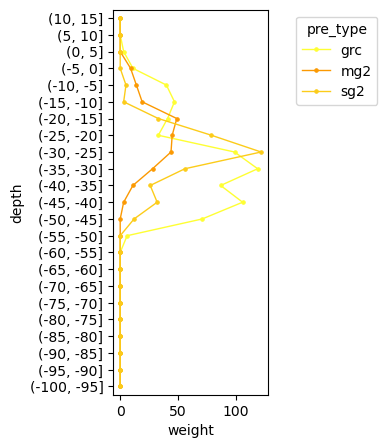

In [182]:
# Create a seaborn plot
hfig,ax = plt.subplots(1,figsize=(2,5))
sns.pointplot(data=df_grouped,y='depth', x='weight',hue = 'pre_type',palette=syn_colors,linewidth=1)#,order = ['lg','mg1','sg1','lf','mg2','sg2'])
ax.invert_yaxis()
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.75, 1));
plt.savefig('/Users/kperks/Downloads/lg_pre_synapse_locations_binned.svg',transparent=True) 

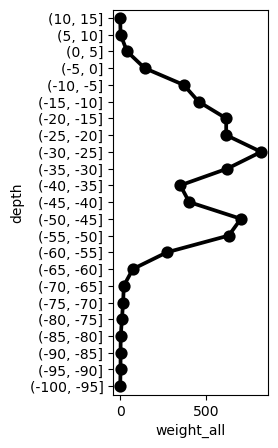

In [230]:
hfig,ax = plt.subplots(1,figsize=(2,5))
sns.pointplot(data=df_grouped,y='depth', x='weight_all',color='black')
ax.invert_yaxis()

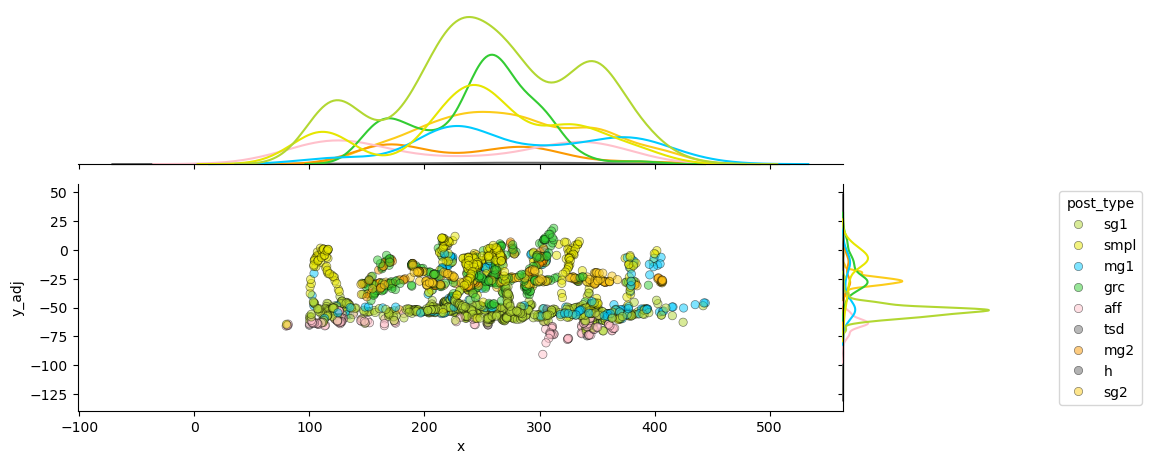

In [58]:
mask = df_syn['pre_type'].isin(['mg2','mg1']) & df_syn['post_type'].isin(['aff','grc','smpl','sg1','sg2','mg1','mg2','tsd','h'])
g = sns.jointplot(data=df_syn[mask], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="post_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','mg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
#                   x="x", y="z", hue="pre_type", height=10,
#                   alpha = 0.5, edgecolor='black',palette = syn_colors,
#                  marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# # sns.scatterplot(x=[0],y=[0],color='black',s=100);

# sns_joint_equal_axes(g);
# sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# Connectivity Similarity

## correlation

In [116]:
# Desired source and order
source_types_order = ['lg','mg1','sg1','smpl','lf','mg2','sg2','grc']#['aff','smpl','sgx1','sg1','mg1','grc','sgx2','sg2','mg2']#['smpl','sg1','mg1','grc','sg2','mg2']#

# Desired targets order
target_types_order = ['grc', 'smpl', 'sgx2','sgx1','sg2', 'sg1', 'mg2', 'mg1']  #['aff', 'smpl','sgx1','sg1', 'grc', 'sgx2', 'sg2']#

In [117]:
# dsource = 'post_type'
# idsource = 'post'
# dtarget = 'pre_type'

# post-synaptic labeling
dsource = 'post_type'
idsource = 'post'
dtarget = 'pre_type'

# Filter out rows with post_type not in post_types_order
df_edges_filtered = df_edges[df_edges[dsource].isin(source_types_order)]

# Pivot table to get sum of weights per post and pre_type
pivot_df = df_edges_filtered.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

In [118]:
pivot_df.head()

pre_type,post_type,grc,smpl,sgx2,sgx1,sg2,sg1,mg2,mg1
post,,,,,,,,,
301787806,lg,199,1,15,0,157,0,45,0
303969144,lg,10,0,8,4,18,0,28,1
472392041,lg,195,4,10,0,58,1,44,0
300474334,lg,176,0,23,0,61,0,42,0
302637877,lg,5,0,1,0,19,0,43,0


## cosine similarity

In [119]:
def cosine_similarity(A, B):
    # The time-series data sets should be normalized.
    A_norm = (A - np.mean(A)) / np.std(A)
    B_norm = (B - np.mean(B)) / np.std(B)
 
    # Determining the dot product of the normalized time series data sets.
    dot_product = np.dot(A_norm, B_norm)
 
    # Determining the Euclidean norm for each normalized time-series data collection.
    norm_A = np.linalg.norm(A_norm)
    norm_B = np.linalg.norm(B_norm)
 
    # Calculate the cosine similarity of the normalized time series data 
    # using the dot product and Euclidean norms. setse-series data set
    cosine_sim = dot_product / (norm_A * norm_B)
 
    return cosine_sim
    
# from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from numpy.linalg import norm


In [120]:
pivot_df.head()

pre_type,post_type,grc,smpl,sgx2,sgx1,sg2,sg1,mg2,mg1
post,,,,,,,,,
301787806,lg,199,1,15,0,157,0,45,0
303969144,lg,10,0,8,4,18,0,28,1
472392041,lg,195,4,10,0,58,1,44,0
300474334,lg,176,0,23,0,61,0,42,0
302637877,lg,5,0,1,0,19,0,43,0


In [121]:
# Normalize each row to unit length (L2 norm)
pivot_df_corr = pivot_df.drop(columns=[dsource])
# pivot_df_corr=pivot_df_corr.apply(zscore, axis=1) # DO NOT Z-SCORE: it will then just be correlation coefficient 
# (https://stats.stackexchange.com/questions/235673/is-there-any-relationship-among-cosine-similarity-pearson-correlation-and-z-sc)
normalized_df = pivot_df_corr.div(norm(pivot_df_corr, axis=1), axis=0)
normalized_df.dropna(inplace=True)#.replace(np.NaN,0)

In [122]:
cosine_sim_matrix = pairwise_distances(normalized_df, metric='cosine')
cosine_sim_matrix = 1-cosine_sim_matrix
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=normalized_df.index, columns=normalized_df.index)

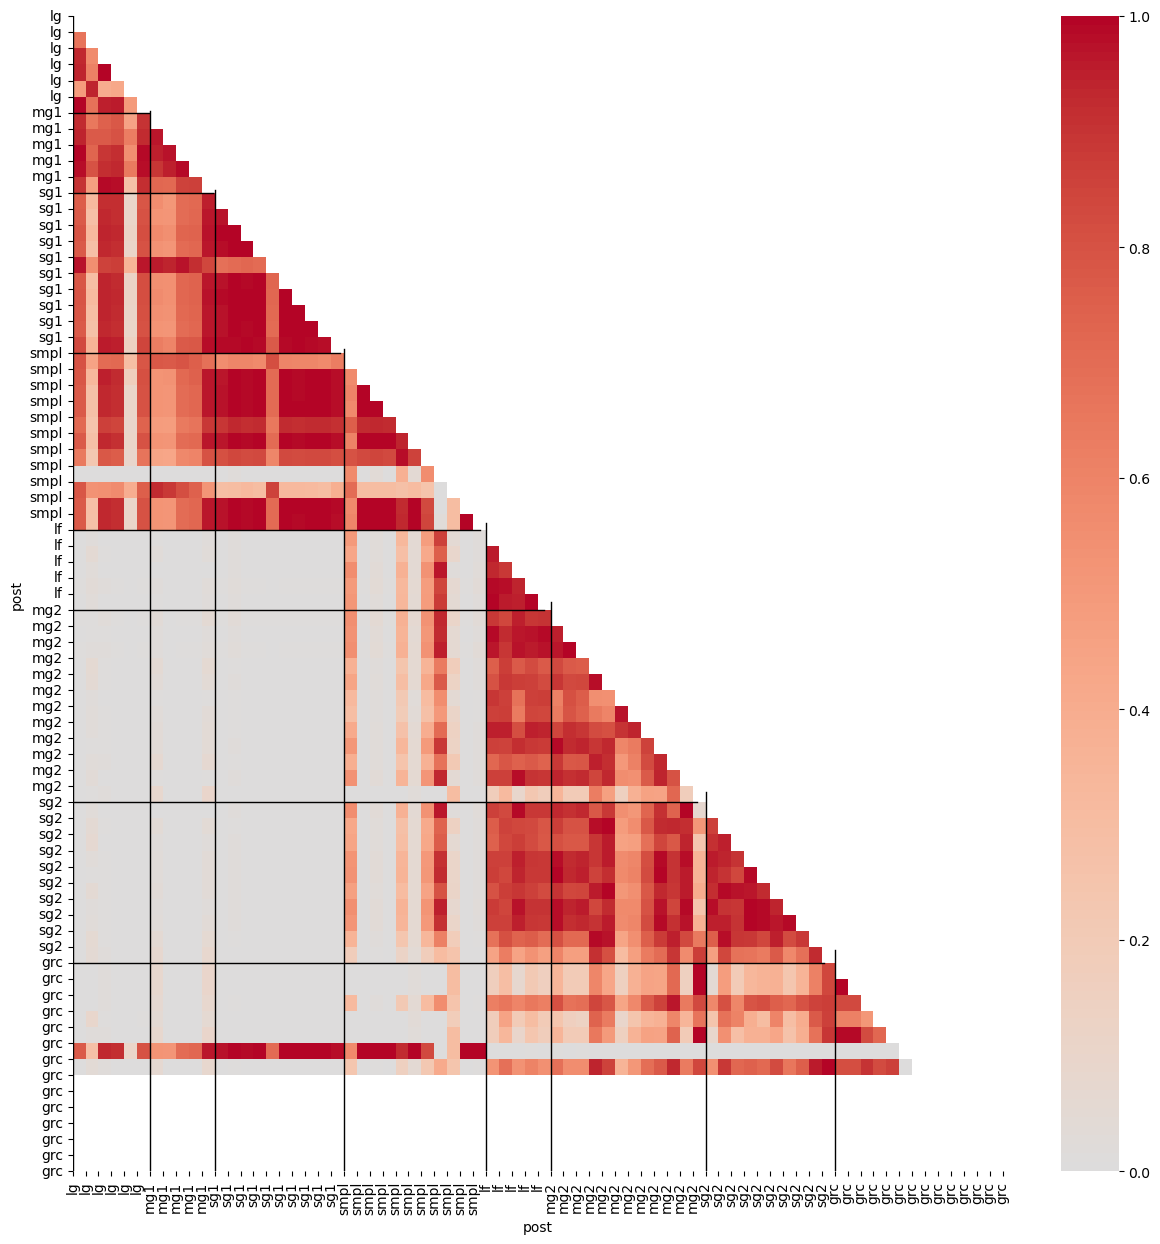

In [124]:
# Create the heatmap
plt.figure(figsize=(15, 15))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cosine_sim_df, dtype=bool))

heatmap = sns.heatmap(cosine_sim_df, mask=mask,cmap='coolwarm', annot=False, fmt='.2f', cbar=True,center=0) #

# Add post_type labels and lines
current_position = 0
total_position=len(pivot_df)
for dtype in source_types_order:
    n = (pivot_df[dsource] == dtype).sum()
    if n > 0:
        # heatmap.axhline(current_position,current_position/len(pivot_df), total_position, color='black', linewidth=1)
        # heatmap.axvline(current_position,1-(current_position/len(pivot_df)), total_position, color='black', linewidth=1)
        heatmap.axhline(current_position,0, current_position/len(pivot_df), color='black', linewidth=1)
        heatmap.axvline(current_position,0, 1-(current_position/len(pivot_df)), color='black', linewidth=1)
        current_position += n
heatmap.axhline(current_position, color='black', linewidth=1)
heatmap.axvline(current_position, color='black', linewidth=1)

# Set labels
heatmap.set_xticks(range(0,len(pivot_df)))
heatmap.set_yticks(range(0,len(pivot_df)))
heatmap.set_xticklabels(pivot_df[dsource].values, rotation=90)
heatmap.set_yticklabels(pivot_df[dsource].values, rotation=0)

# plt.title('Similarity Heatmap')
# plt.show()
plt.savefig('/Users/kperks/Downloads/all-types_cosine_similarity_input.svg',transparent=True) 

# Connection patterns

In [108]:
count_type = 'nsyn' # 'ncells' #
mask = (df_edges['pre_type'].isin(['aff','grc','smpl','sg1','sg2']))#,'mli','tsd','dml'])) # df_edges['pre'].isin([290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) & 
#[295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424]

types_ = ['lg','lf'] #['mg1','mg2']#, 
df_map = pd.DataFrame()
for t in types_:
    if count_type == 'nsyn':
        df_grouped = df_edges[(df_edges['post_type']==t) & mask].groupby(
            ['post','post_type','pre_type']).sum(numeric_only=True).reset_index().pivot(
            index='post', columns='pre_type', values='weight').fillna(0).reset_index()
    
    if count_type == 'ncells':
        df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
            ['pre','pre_type','post_type']).count().reset_index().pivot(
            index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['post_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)
df_map = df_map.set_index('post')
df_map = df_map.drop(['post_type'],axis=1)

In [109]:
df_map.head()

pre_type,grc,sg1,sg2,smpl,aff
post,,,,,
300474334,176.0,0.0,61.0,0.0,0.0
301727988,78.0,0.0,55.0,0.0,0.0
301787806,199.0,0.0,157.0,1.0,0.0
302637877,5.0,0.0,19.0,0.0,0.0
303969144,10.0,0.0,18.0,0.0,0.0


## connectivity heatmap

[]

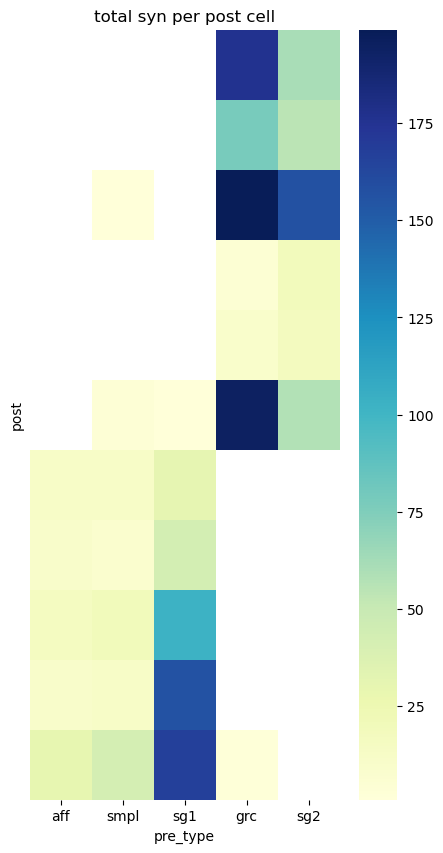

In [110]:
target_order = ['aff','smpl','sg1','grc','sg2']#['lg','mg1','lf','mg2']#['lg','mg1','sg1','lf','mg2','sg2']#
df_map = df_map.loc[:,[t for t in target_order if t in df_map.columns.values]]

cmap = sns.color_palette("YlGnBu", as_cmap=True)  # Base colormap
cmap.set_under('white')  # Set color for values below the colormap's minimum (i.e., 0)

# Ensure all 0s are treated as "under" the colormap range
# df_map = df_map.replace(0, -1)  # Replace 0s with a value below the colormap range


# fig, axes = plt.subplots(1, figsize=(5,10))
# sns.heatmap(data=df_map.sort_values(['lg']), annot=False, fmt="0.0f", cmap="YlGnBu", ax=axes)#  .sort_index()
# # sns.heatmap(data=df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])
# axes.set_title('total syn per pre cell')




# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=df_map.sort_values(['sg1']), annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per post cell')
axes.set_yticks([])



In [111]:
sg1_map = df_map[df_map['sg1']>1].sort_values(['sg1'])

In [112]:
sg2_map = df_map[~df_map.index.isin(sg1_map.index)].sort_values(['sg2'],ascending=False)

In [113]:
sorted_full = pd.concat([sg2_map,sg1_map])

[]

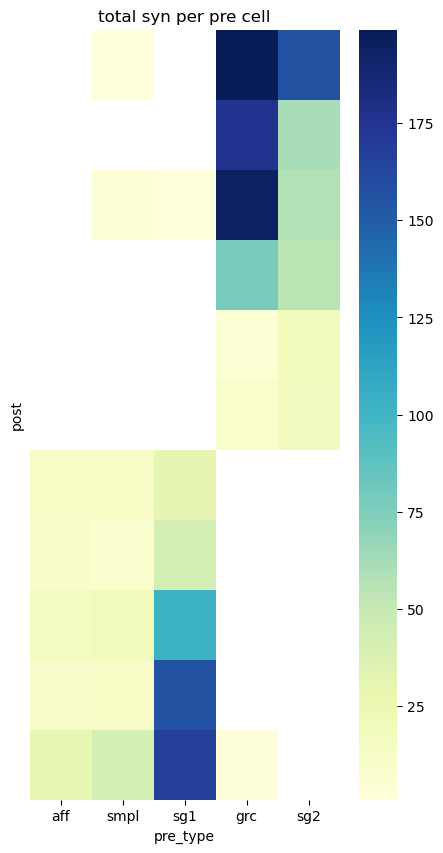

In [114]:
# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=sorted_full, annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])

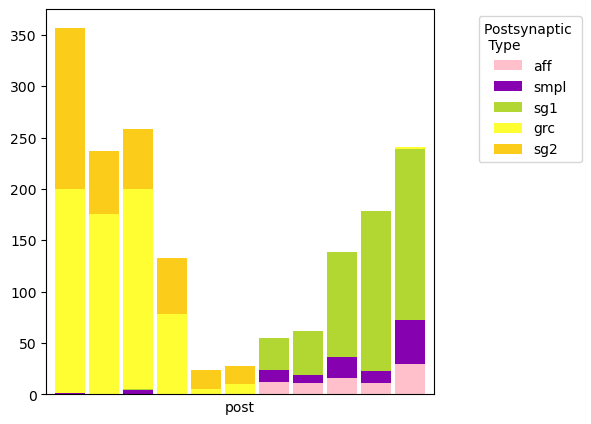

In [115]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
# Create a stacked bar plot
sorted_full.loc[:,target_order].plot.bar(stacked=True,color = syn_colors,ax=ax, width=0.9)
ax.set_xticks([])
ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.4, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/output_stacked_bar_presyn.svg', format='svg', transparent=True)

In [221]:
df_norm = df_map.div(df_map.sum(axis=1),axis=0).mul(100)#.round(0)

In [222]:
sg1_map = df_norm[df_norm['sg1']>1].sort_values(['sg1'])

sg2_map = df_norm[~df_norm.index.isin(sg1_map.index)].sort_values(['sg2'],ascending=False)

norm_sorted_full = pd.concat([sg2_map,sg1_map])

[]

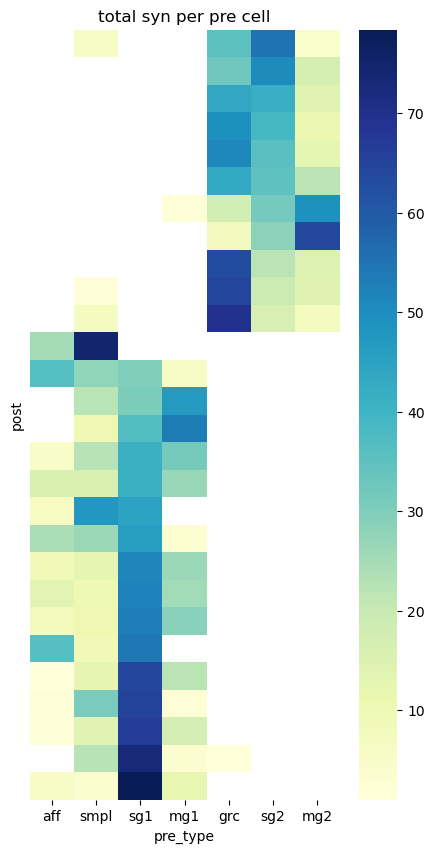

In [223]:
# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=norm_sorted_full, annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])

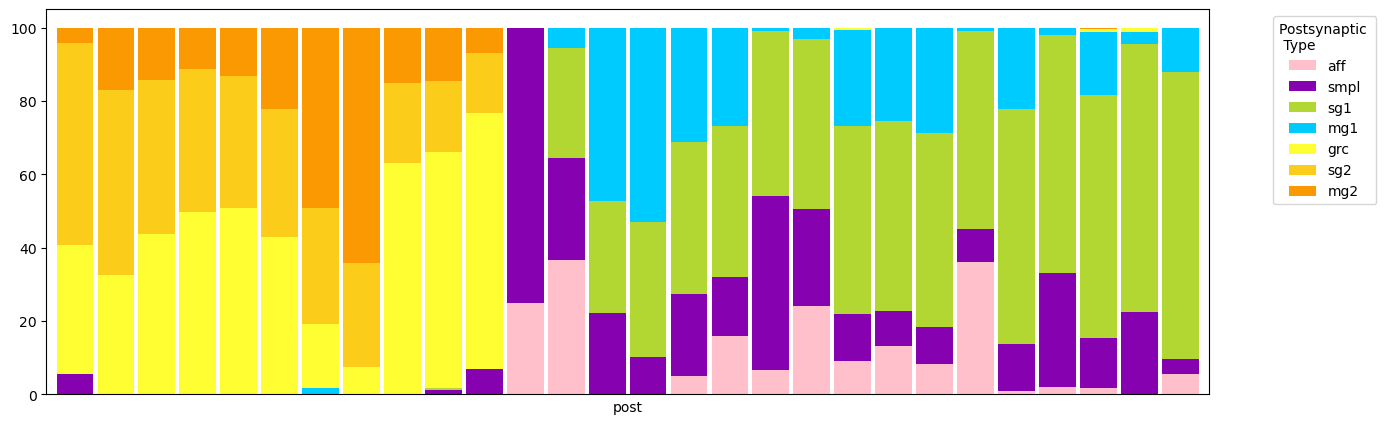

In [224]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
# Create a stacked bar plot
norm_sorted_full.loc[:,target_order].plot.bar(stacked=True,color = syn_colors,ax=ax, width=0.9)
ax.set_xticks([])
ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/mg_output_stacked_bar_presyn_normalized.svg', format='svg', transparent=True)

# KC fig 4 analysis

In [225]:
def get_p_connect(df_edges,mask,count_type):

# count_type = 'nsyn' # 'ncells' #
# mask = (df_edges['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf']))#,'mli','tsd','dml'])) # df_edges['pre'].isin([290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) & 
#[295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424]

    types_ = ['mg1','mg2','lg','lf']# 
    df_map = pd.DataFrame()
    for t in types_:
        if count_type == 'nsyn':
            df_grouped = df_edges[(df_edges['post_type']==t) & mask].groupby(
                ['post','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
                index='post', columns='pre_type', values='weight').fillna(0).reset_index()
        
        # if count_type == 'ncells':
        #     df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
        #         ['pre','pre_type','post_type']).count().reset_index().pivot(
        #         index='pre', columns='post_type', values='post').fillna(0).reset_index()
        
        df_grouped['post_type']=t
        df_map = pd.concat([df_map,df_grouped])
        
    df_map = df_map.fillna(0)
    df_map = df_map.set_index('post')
    df_map = df_map.drop(['post_type'],axis=1)
    
    
    df_norm = df_map.div(df_map.sum(axis=1),axis=0)#.mul(100).round(0)

    return df_norm
# sns.heatmap(data=df_norm.sort_values('lcf'), annot=True, fmt="0.0f", cmap="YlGnBu")

## data

In [228]:
df_syn['post'].nunique()

80

In [229]:
df_syn.head()

,Unnamed: 0,post,pre,structure,x,y,z,y_adj,pre_type,post_type,depth
0,0,126649726,305329558,axon,333.376,306.304,50.70,-49.606710,sg1,mg2,"(-50, -45]"
1,1,126649726,221714230,axon,341.472,295.248,37.11,-40.070481,smpl,mg2,"(-45, -40]"
2,2,126649726,302730452,axon,229.456,307.280,52.86,-51.985349,sg1,mg2,"(-55, -50]"
3,3,126649726,44244249,axon,337.200,270.496,19.05,-17.969978,smpl,mg2,"(-20, -15]"
4,4,126649726,559551706,axon,322.752,307.680,65.13,-49.580579,mg1,mg2,"(-50, -45]"


## connection probability by cell type

In [233]:
count_type = 'nsyn'
included_groups = ['aff','smpl','sg1','mg1','grc','sg2','mg2']
by_group='mg1'

### data

In [231]:
# df_edges=df_syn.drop(['Unnamed: 0','x','y','z','y_adj','structure','depth'],axis=1).value_counts().reset_index(name='weight')

mask = (df_edges['pre_type'].isin(included_groups))

df_norm_data = get_p_connect(df_edges,mask,count_type)

result_data = df_norm_data[(df_norm_data[by_group] != 0)].mean()

### shuffle result

In [232]:
result_df = pd.DataFrame()

df_syn_rand = deepcopy(df_syn)

# Iterate the specified number of times
for i in range(100):
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_rand[['post','post_type']].sample(frac = 1)
    df_syn_rand.loc[:,['post']] = shuff_rows['post'].values
    df_syn_rand.loc[:,['post_type']] = shuff_rows['post_type'].values

    df_edges_shuff=df_syn_rand.drop(['Unnamed: 0','x','y','z','y_adj','structure','depth'],axis=1).value_counts().reset_index(name='weight')
    mask = (df_edges_shuff['pre_type'].isin(included_groups))

    df_norm = get_p_connect(df_edges_shuff,mask,count_type)
    
    # Compute the mean for rows where 'mg2' is not zero
    mean_row = df_norm[(df_norm[by_group] != 0)].mean(numeric_only=True) #df_shuffled[df_shuffled[by_group] != 0].mean(numeric_only=True)
    
    # Append the result as a row to the result_df
    result_df = pd.concat([result_df, pd.DataFrame([mean_row])], ignore_index=True)

### plot comparison

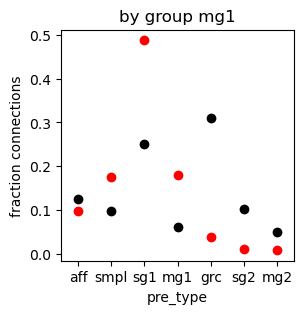

In [237]:
hfig,ax = plt.subplots(1,figsize=(3,3))

# plot single iteration, individual cells
# sns.pointplot(data = df_norm,linestyle='',color = 'black',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'],errorbar='sd')
# sns.pointplot(data=df_norm_data[(df_norm_data[by_group] != 0)],linestyle='',color = 'red',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'],errorbar='sd')

# plot iteration means
sns.pointplot(data = result_df,linestyle='',color = 'black',markersize = 5,order = included_groups,errorbar=('ci'))
sns.pointplot(data=result_data,linestyle='',color = 'red',markersize = 5,order = included_groups)

ax.set_ylabel('fraction connections')
ax.set_title(f'by group {by_group}')

plt.savefig(f'/Users/kperks/Downloads/input_conditionalP_{by_group}.svg', format='svg', transparent=True)

# Patterns of connectivity (PCA)

In [238]:
def calculate_percent_total(row):
    total = row.sum()
    if total == 0:
        return row  # If total is 0, return the row as is (unchanged)
    else:
        return row / total  # Normalize by dividing each element by the total
#row / total 

## params of analysis

In [239]:
# post-synaptic labeling
dsource = 'post_type'
idsource = 'post'
dtarget = 'pre_type'

# Desired pre_types and order
source_types_order = ['lg','mg1','lf','mg2']#['pf']#
# Desired post_types order
target_types_order =  ['aff', 'smpl', 'sg1','mg1', 'grc', 'sg2','mg2']#['mg1','lg', 'mg2','lf'] #

## data

In [240]:
# df_edges=df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

# Filter out rows with post_type not in post_types_order
df_edges_filtered = df_edges[df_edges[dsource].isin(source_types_order)]

# Pivot table to get sum of weights per post and pre_type
pivot_df = df_edges_filtered.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

# Apply the function to each row
# norm_df = pivot_df.drop(columns=dsource).apply(calculate_percent_total, axis=1)
norm_df = pivot_df.select_dtypes(include='number').apply(calculate_percent_total, axis=1)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(norm_df)

# Perform PCA
npc = len(target_types_order)
pca = PCA(n_components=npc)  # You can change the number of components as needed

pca_result = pca.fit_transform(scaled_data)

# get loadings of dimensions onto each principal component
loadings = pca.components_.T

# Add PCA results to the DataFrame
for i in range(npc):
    pivot_df[str(i)] = pca_result[:, i]

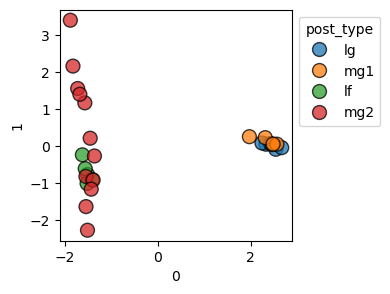

In [241]:
hfig,ax = plt.subplots(1,figsize=(3,3))
sns.scatterplot(ax=ax,data=pivot_df,hue=dsource,x='0',y='1',linewidth=1,edgecolor='black',s=100,alpha = 0.75)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [242]:
result_data = pd.DataFrame(pca.explained_variance_ratio_.reshape(1, -1),columns=range(len(pca.explained_variance_ratio_)))

### shuffle result

In [243]:
result_df = pd.DataFrame()

df_syn_rand = deepcopy(df_syn)

# Iterate the specified number of times
for i in range(50):
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_rand[['post','post_type']].sample(frac = 1)
    df_syn_rand.loc[:,['post']] = shuff_rows['post'].values
    df_syn_rand.loc[:,['post_type']] = shuff_rows['post_type'].values
    
    df_edges_shuff=df_syn_rand.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')
    # Filter out rows with post_type not in post_types_order
    df_edges_filtered = df_edges_shuff[df_edges_shuff[dsource].isin(source_types_order)]
    
    # Pivot table to get sum of weights per post and pre_type
    pivot_df = df_edges_filtered.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)
    
    # Reindex columns to include only the specified pre_types in the desired order
    pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)
    
    # Reset index to turn 'post' and 'post_type' from index to columns
    pivot_df.reset_index(inplace=True)
    
    # Sort the dataframe based on post_type
    pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
    pivot_df.sort_values(dsource, inplace=True)
    pivot_df.set_index(idsource, inplace=True)
    
    # Apply the function to each row
    # norm_df = pivot_df.drop(columns=dsource).apply(calculate_percent_total, axis=1)
    norm_df = pivot_df.select_dtypes(include='number').apply(calculate_percent_total, axis=1)
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(norm_df)
    
    # Perform PCA
    npc = len(target_types_order)
    pca = PCA(n_components=npc)  # You can change the number of components as needed
    pca_result = pca.fit_transform(scaled_data)

        # get loadings of dimensions onto each principal component
    loadings = pca.components_.T
    
    # Add PCA results to the DataFrame
    for i in range(npc):
        pivot_df[str(i)] = pca_result[:, i]
    
    # Append the result as a row to the result_df
    result_df = pd.concat([result_df, pd.DataFrame(pca.explained_variance_ratio_.reshape(1, -1))], ignore_index=True)

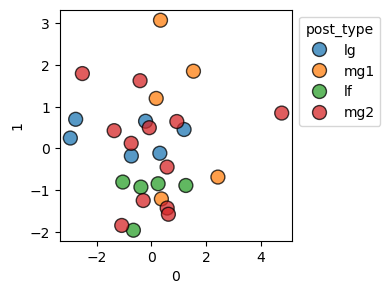

In [244]:
hfig,ax = plt.subplots(1,figsize=(3,3))
sns.scatterplot(ax=ax,data=pivot_df,hue=dsource,x='0',y='1',linewidth=1,edgecolor='black',s=100,alpha = 0.75)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

### plot comparison

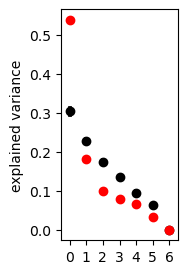

In [245]:
hfig,ax = plt.subplots(1,figsize=(1.5,3))

# plot single iteration, individual cells
# sns.pointplot(data = df_norm,linestyle='',color = 'black',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'])
# sns.pointplot(data=df_norm_data[(df_norm_data[by_group] != 0)],linestyle='',color = 'red',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'])

# plot iteration means
sns.pointplot(data = result_df,linestyle='',color = 'black',markersize = 5,errorbar='ci')
sns.pointplot(data=result_data,linestyle='',color = 'red',markersize = 5)

ax.set_ylabel('explained variance')
plt.savefig(f'/Users/kperks/Downloads/input_pca.svg', format='svg', transparent=True)

# OTHER

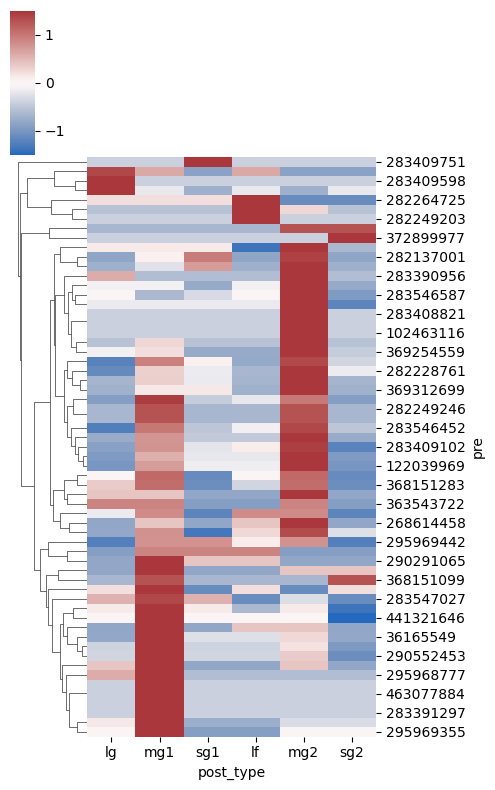

In [180]:

# sns.set(font_scale=1.4)
sns.clustermap(data=df_map,z_score=0,cmap='vlag',col_cluster=False, vmin=-1.5, vmax=1.5,figsize=(5,8))

<Axes: xlabel='lf', ylabel='mg1'>

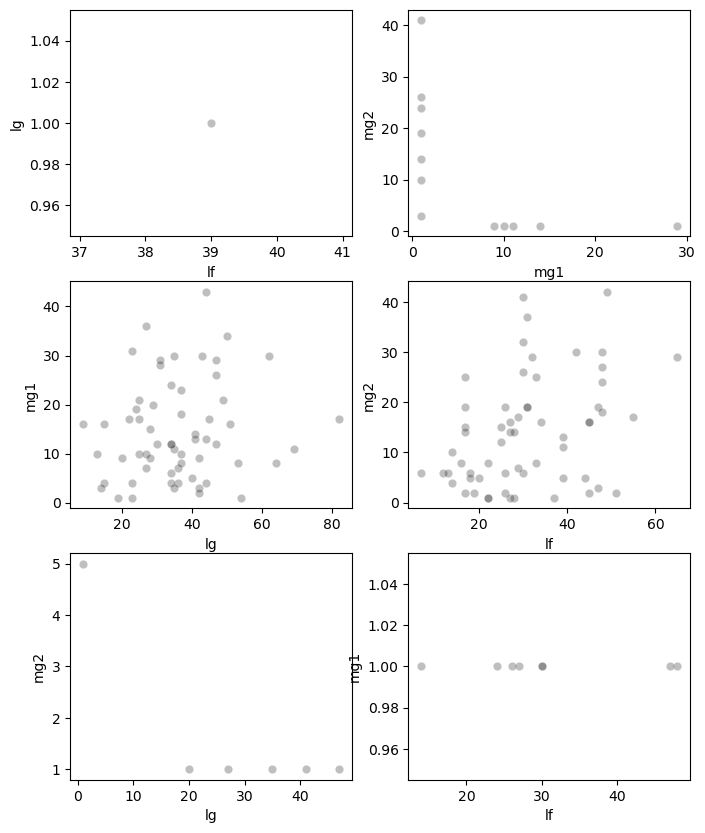

In [163]:
hfig,ax = plt.subplots(3,2,figsize=(8,10))
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['lf'] != 0)], x = 'lf', y = 'lg', ax = ax[0][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['mg1'] != 0)& (df_map['mg2'] != 0)], x = 'mg1', y = 'mg2', ax = ax[0][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['mg1'] != 0)], x = 'lg', y = 'mg1', ax = ax[1][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lf'] != 0)& (df_map['mg2'] != 0)], x = 'lf', y = 'mg2', ax = ax[1][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['mg2'] != 0)], x = 'lg', y = 'mg2', ax = ax[2][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lf'] != 0)& (df_map['mg1'] != 0)], x = 'lf', y = 'mg1', ax = ax[2][1],alpha = 0.25,color = 'black')